In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt; import seaborn as sns

In [2]:
df = utils.load_data("UCBadmit")
df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [3]:
df['percent_of_addmisions'] = round(df['admit']/df['applications']*100,2)
df

,dept,applicant.gender,admit,reject,applications,percent_of_addmisions
1,A,male,512,313,825,62.06
2,A,female,89,19,108,82.41
3,B,male,353,207,560,63.04
4,B,female,17,8,25,68.00
5,C,male,120,205,325,36.92
6,C,female,202,391,593,34.06
7,D,male,138,279,417,33.09
8,D,female,131,244,375,34.93
9,E,male,53,138,191,27.75
10,E,female,94,299,393,23.92


<Axes: xlabel='dept', ylabel='percent_of_addmisions'>

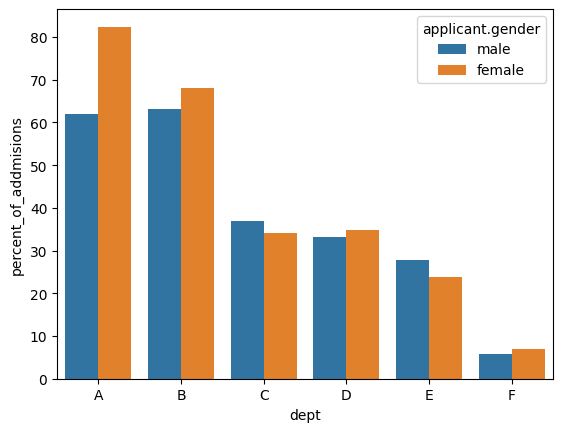

In [4]:
sns.barplot(data=df, x="dept", y="percent_of_addmisions", hue="applicant.gender")

# Rethinking

## (1) ESTIMAND
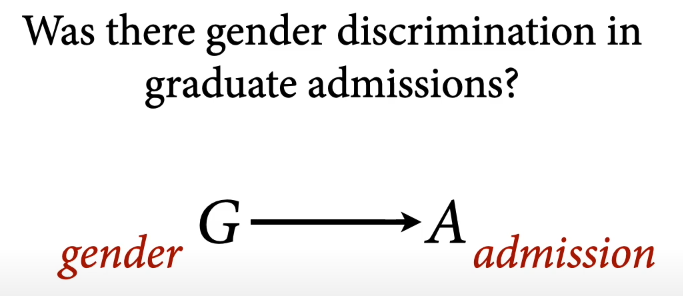

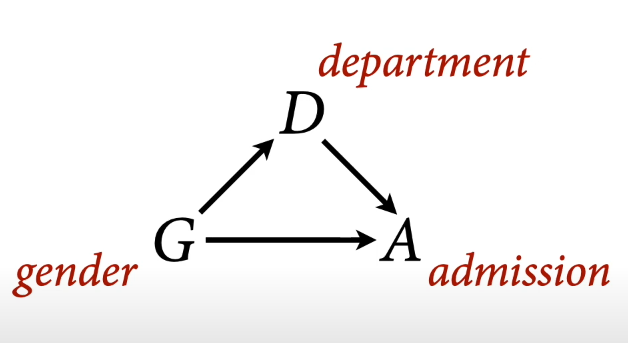

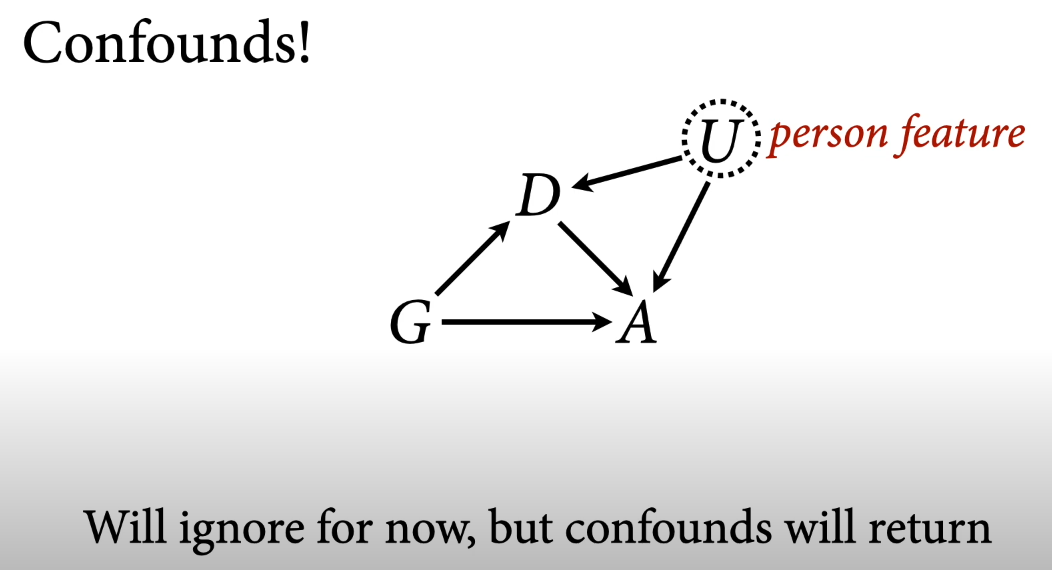

## (2) Scientific Model(s):

####  Simulate the process

In [5]:
np.random.seed(123)
n_samples = 1000

GENDER = stats.bernoulli.rvs(p=.5, size=n_samples)

# # Groundtruth parameters
# # Gender 1 tends to apply to department 1
P_DEPARTMENT = np.where(GENDER==0, .3, .8)

# # Acceptance rates matrices -- Department x Gender
UNBIASED_ACCEPTANCE_RATES = np.array([[.1, .1], [.3, .3]])  # No *direct* gender bias

# # Biased acceptance: 
# # - dept 0 accepts gender 0 at 50% of unbiased rate 
# # - dept 1 accepts gender 0 at 67% of unbiased rate
BIASED_ACCEPTANCE_RATES = np.array([[.05, .1], [.2, .3]])   # *direct* gender bias present

DEPARTMENT = stats.bernoulli.rvs(p=P_DEPARTMENT, size=n_samples).astype(int)
UNBIASED_ACCEPTANCE_RATES

array([[0.1, 0.1],
       [0.3, 0.3]])

In [6]:
BIASED_ACCEPTANCE_RATES

array([[0.05, 0.1 ],
       [0.2 , 0.3 ]])

In [7]:
# Biased Acceptance:
# dept 0 accepts gender 0 at 50% of unbiased rate
# dept 1 accepts gender 0 at 67 % of unbiased rate

BIASED_ACCEPTANCE_RATES = np.array([[
    0.1*0.5, 0.1],
    [0.3*0.67, 0.3
]])
BIASED_ACCEPTANCE_RATES

array([[0.05 , 0.1  ],
       [0.201, 0.3  ]])

In [8]:
UNBIASED_ACCEPTANCE_RATES[DEPARTMENT]

array([[0.3, 0.3],
       [0.1, 0.1],
       [0.1, 0.1],
       ...,
       [0.1, 0.1],
       [0.3, 0.3],
       [0.1, 0.1]])

In [9]:
def simulate_admissions_data(bias_type):
    """Simulate admissions data using the global params above"""
    acceptance_rate = BIASED_ACCEPTANCE_RATES if bias_type == 'biased' else UNBIASED_ACCEPTANCE_RATES
    acceptance = stats.bernoulli.rvs(p=acceptance_rate[DEPARTMENT, GENDER])
    
    return pd.DataFrame(
        np.vstack([GENDER, DEPARTMENT, acceptance]).T,
        columns=['gender', 'department', 'accepted']
    ), acceptance_rate

for bias_type in ['unbiased', 'biased']:

    fake_admissions, acceptance_rate = simulate_admissions_data(bias_type)
    
    gender_acceptance_counts = fake_admissions.groupby(["gender", "accepted"]).count()['department']
    gender_acceptance_counts.name = None
    
    gender_department_counts = fake_admissions.groupby(["gender", "department"]).count()['accepted']
    gender_department_counts.name = None
    
    observed_acceptance_rates = fake_admissions.groupby("gender").mean()['accepted']
    observed_acceptance_rates.name = None
    
    print()
    print('-' * 30)
    print(bias_type.upper())
    print('-' * 30)
    print(f'Department Acceptance rate:\n{acceptance_rate}')
    print(f'\nGender-Department Frequency:\n{gender_department_counts}')
    print(f'\nGender-Acceptance Frequency:\n{gender_acceptance_counts}')
    print(f'\nOverall Acceptance Rates:\n{observed_acceptance_rates}')


------------------------------
UNBIASED
------------------------------
Department Acceptance rate:
[[0.1 0.1]
 [0.3 0.3]]

Gender-Department Frequency:
gender  department
0       0             335
        1             173
1       0             106
        1             386
dtype: int64

Gender-Acceptance Frequency:
gender  accepted
0       0           437
        1            71
1       0           359
        1           133
dtype: int64

Overall Acceptance Rates:
gender
0    0.139764
1    0.270325
dtype: float64

------------------------------
BIASED
------------------------------
Department Acceptance rate:
[[0.05  0.1  ]
 [0.201 0.3  ]]

Gender-Department Frequency:
gender  department
0       0             335
        1             173
1       0             106
        1             386
dtype: int64

Gender-Acceptance Frequency:
gender  accepted
0       0           465
        1            43
1       0           370
        1           122
dtype: int64

Overall Acceptance Rates:


#### My version of the generative simulation

In [10]:
np.random.seed(123)
n_samples = 1000 # number of people

gender = stats.bernoulli.rvs(p=0.5,size=n_samples) # simulating gender
sim_df = pd.DataFrame(gender, columns=["Gender"])
sim_df["Gender"] = sim_df["Gender"].map({0: "Female", 1: "Male"})

# Females tend to apply to department of psychology (psych), Males tend to apply to department of Informations Technology (it)
sim_df["probability_of_applying_to_department_psychology"] = np.where(sim_df["Gender"]=="Female", 0.8, 0.3)

sim_df["applying_to"] = stats.bernoulli.rvs(p=sim_df["probability_of_applying_to_department_psychology"])
sim_df["applying_to"] = np.where(sim_df["applying_to"]==0, "it", "psych")

# the acceptance rate for it dept is 0.3, whereas for psychology it is 0.1
sim_df['unbiased_acceptance_rate'] = np.where(sim_df['applying_to']=="it", 0.3, 0.1)

# the biased acceptance rate for it is 0.2 for females. for psych its 0.05 for females. same for males
sim_df['biased_acceptance_rate'] = np.where((sim_df["Gender"]=="Female")&(sim_df["applying_to"]=="it"), 0.2, 
                                            np.where((sim_df["Gender"]=="Male")&(sim_df["applying_to"]=="it"), 0.3,
                                            np.where((sim_df["Gender"]=="Female")&(sim_df["applying_to"]=="psych"), 0.05, 0.1)))

sim_df['accepted_unbiased'] = stats.bernoulli.rvs(p=sim_df['unbiased_acceptance_rate'])
sim_df['accepted_biased'] = stats.bernoulli.rvs(p=sim_df['biased_acceptance_rate'])

In [11]:
sim_df

,Gender,probability_of_applying_to_department_psychology,applying_to,unbiased_acceptance_rate,biased_acceptance_rate,accepted_unbiased,accepted_biased
0,Male,0.3,it,0.3,0.30,0,1
1,Female,0.8,psych,0.1,0.05,0,0
2,Female,0.8,psych,0.1,0.05,0,0
3,Male,0.3,it,0.3,0.30,1,1
4,Male,0.3,it,0.3,0.30,0,0
...,...,...,...,...,...,...,...
995,Female,0.8,psych,0.1,0.05,0,0
996,Male,0.3,psych,0.1,0.10,0,0
997,Female,0.8,psych,0.1,0.05,0,0
998,Female,0.8,psych,0.1,0.05,0,0


In [12]:
sim_df.groupby(by=["Gender", "applying_to"])['accepted_unbiased'].count()

Gender  applying_to
Female  it             115
        psych          393
Male    it             334
        psych          158
Name: accepted_unbiased, dtype: int64

In [13]:
sim_df.groupby("Gender")['accepted_unbiased'].mean() # unbiased acceptance rates
sim_df.groupby("Gender")['accepted_biased'].mean() # biased acceptance rates

Gender
Female    0.072835
Male      0.229675
Name: accepted_biased, dtype: float64

In [14]:
sim_df.groupby("Gender")['accepted_biased'].mean() # biased acceptance rates

Gender
Female    0.072835
Male      0.229675
Name: accepted_biased, dtype: float64

In [15]:
pd.crosstab(sim_df["Gender"], sim_df["applying_to"], normalize="index")

applying_to,it,psych
Gender,,
Female,0.226378,0.773622
Male,0.678862,0.321138


In [16]:
pd.crosstab(sim_df["Gender"], sim_df["accepted_unbiased"], normalize="index")

accepted_unbiased,0,1
Gender,,
Female,0.88189,0.11811
Male,0.75000,0.25000


#### Unbiased scenario:
- due to lower acceptance rates in dept 0 and tendency of gender 0 to apply to dept 0, gender 0 has a lower overall rejection rate compared to gender 1
- due to higher acceptance rates in dept 1 and tendency of gender 1 to apply to dept 1, gender 1 has a higher overall acceptance rate compared to gender 0
- even in the case of no (direct) gender discrimination, **there is still indirect discrimination based on tendency of genders to apply to different departments, and the unqual likelihood that each department accepts students.**

#### Biased scenario
- overall acceptance rates are lower (due to baseline reduction in gender 0 acceptance rates across both departments)
- in the scenario where there is actual department bias, **we see a similar overall _pattern_ of discrimination as the unbiased case due to the indirect effect.**

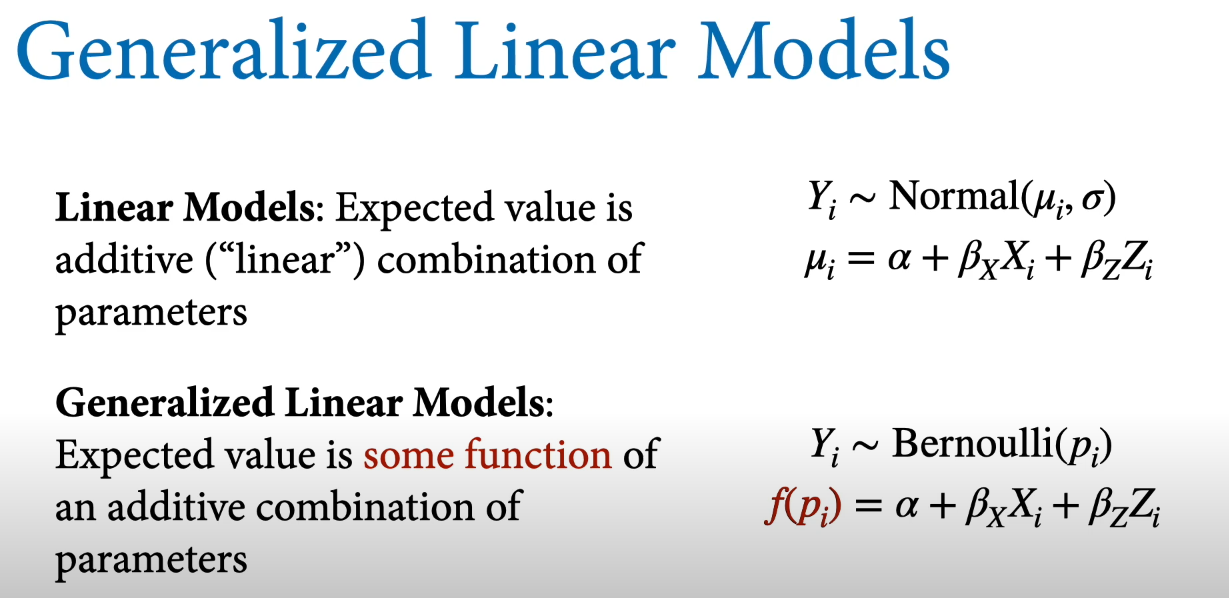

## Statistical models for admissions
Again, the estimator will depend on the estimand

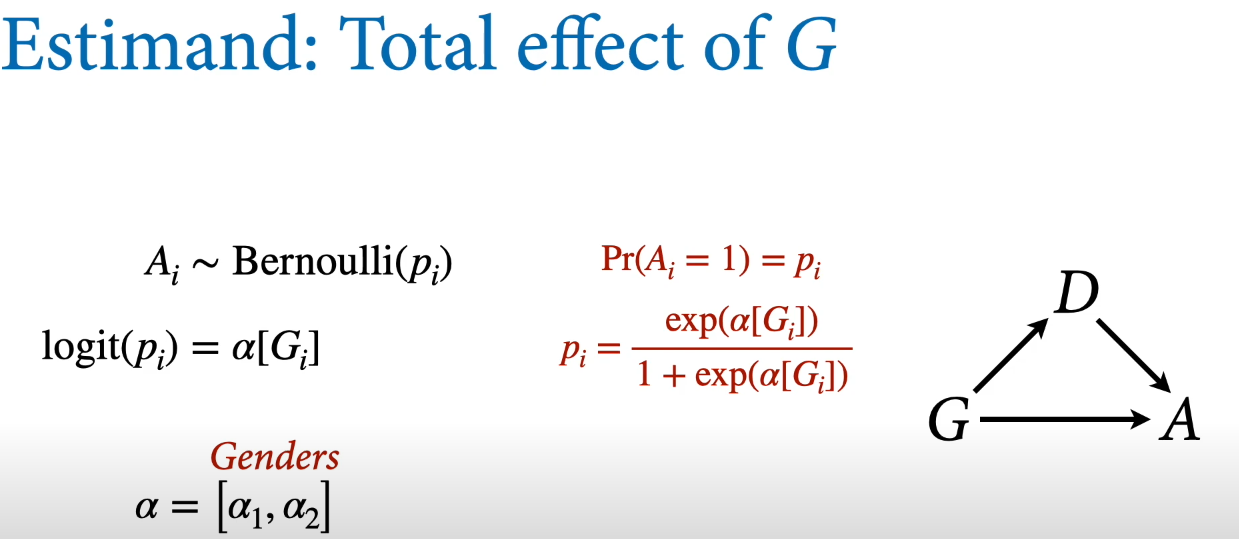

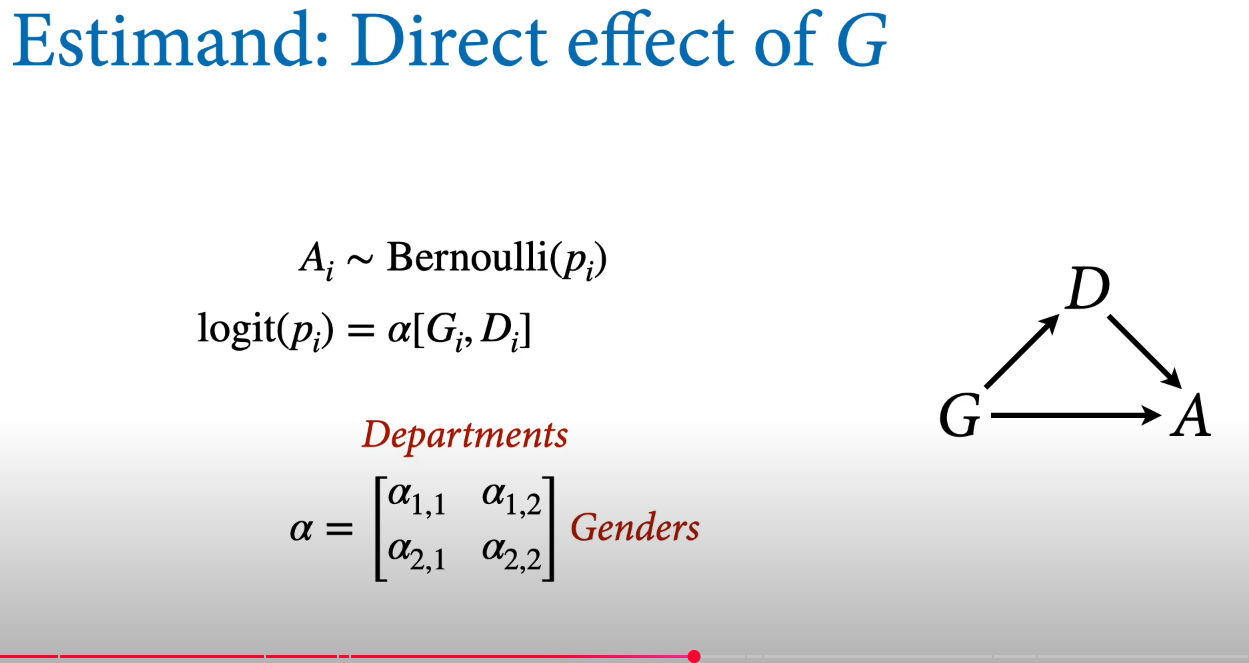

**Stratify by Gender and Department** to block the Pipe


In [17]:
sim_df

,Gender,probability_of_applying_to_department_psychology,applying_to,unbiased_acceptance_rate,biased_acceptance_rate,accepted_unbiased,accepted_biased
0,Male,0.3,it,0.3,0.30,0,1
1,Female,0.8,psych,0.1,0.05,0,0
2,Female,0.8,psych,0.1,0.05,0,0
3,Male,0.3,it,0.3,0.30,1,1
4,Male,0.3,it,0.3,0.30,0,0
...,...,...,...,...,...,...,...
995,Female,0.8,psych,0.1,0.05,0,0
996,Male,0.3,psych,0.1,0.10,0,0
997,Female,0.8,psych,0.1,0.05,0,0
998,Female,0.8,psych,0.1,0.05,0,0


What happens below is preparing the data to be in same format as the real uc berkeley sample. Aggregations to use the same model as the real sample

That is Binomial regression, instead of Bernoulli likelihood (Logistic regression)

In [31]:
sim_data_grouped_biased = sim_df.groupby(by=["Gender", "applying_to"]).agg(
    applications=("accepted_biased", "count"),  # Count of total applications
    admit=("accepted_biased", "sum"),       # Sum of accepted_biased
).reset_index()

sim_data_grouped_biased['reject'] = sim_data_grouped_biased['applications']-sim_data_grouped_biased['admit']
sim_data_grouped_biased.columns = ['applicant.gender', 'dept', 'applications', 'admit', 'reject']

sim_data_grouped_biased

,applicant.gender,dept,applications,admit,reject
0,Female,it,115,17,98
1,Female,psych,393,20,373
2,Male,it,334,102,232
3,Male,psych,158,11,147


In [32]:
sim_data_grouped_unbiased = sim_df.groupby(by=["Gender", "applying_to"]).agg(
    applications=("accepted_unbiased", "count"),  # Count of total applications
    admit=("accepted_unbiased", "sum"),       # Sum of accepted_biased
).reset_index()

sim_data_grouped_unbiased['reject'] = sim_data_grouped_unbiased['applications']-sim_data_grouped_biased['admit']
sim_data_grouped_unbiased.columns = ['applicant.gender', 'dept', 'applications', 'admit', 'reject']

In [33]:
sim_data_grouped_unbiased

,applicant.gender,dept,applications,admit,reject
0,Female,it,115,30,98
1,Female,psych,393,30,373
2,Male,it,334,109,232
3,Male,psych,158,14,147


In [22]:
def fit_total_effect_model_admissions(data):
    
    # Set up observations / coords
    n_admitted = data['admit'].values
    n_applications = data['applications'].values

    gender_coded, gender = pd.factorize(data['applicant.gender'].values)
    
    with pm.Model(coords={"gender": gender}) as total_effect_model:

        # Mutable data for running any gender-based counterfactuals
        gender_coded = pm.MutableData("gender", gender_coded, dims="obs_ids")
        
        alpha = pm.Normal('alpha', 0, 1, dims="gender")
        
        # Record the inverse linked probabilities for reporting
        pm.Deterministic("p_accept", pm.math.invlogit(alpha), dims='gender')
        
        p = pm.math.invlogit(alpha[gender_coded])
        
        likelihood = pm.Binomial("accepted", n=n_applications, p=p, observed=n_admitted, dims="obs_ids")
        total_effect_inference = pm.sample()
    
        return total_effect_model, total_effect_inference

### Fit Total Effect model on BIASED simulated admissions

In [23]:
total_effect_model_simulated_biased, total_effect_inference_simulated_biased = fit_total_effect_model_admissions(sim_data_grouped_biased)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
def plot_admissions_model_posterior(inference, figsize=(6, 2)):
    _, ax = plt.subplots(figsize=figsize)

    # Plot alphas
    az.plot_forest(inference, var_names=['alpha'], combined=True, hdi_prob=.89, ax=ax);

    # Plot inver-linked acceptance probabilities
    _, ax = plt.subplots(figsize=figsize)
    az.plot_forest(inference, var_names=['p_accept'], combined=True, hdi_prob=.89, ax=ax);

    return az.summary(inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Female],-2.483,0.160,-2.773,-2.173,0.003,0.002,2168.0,1553.0,1.0
alpha[Male],-1.198,0.107,-1.392,-0.996,0.002,0.002,2190.0,1318.0,1.0
p_accept[Female],0.078,0.011,0.057,0.100,0.000,0.000,2168.0,1553.0,1.0
p_accept[Male],0.232,0.019,0.199,0.269,0.000,0.000,2190.0,1318.0,1.0


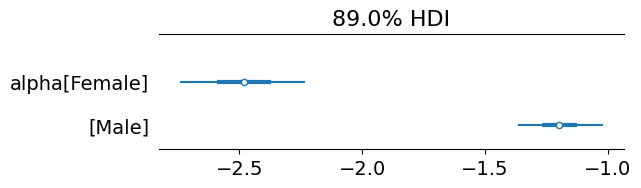

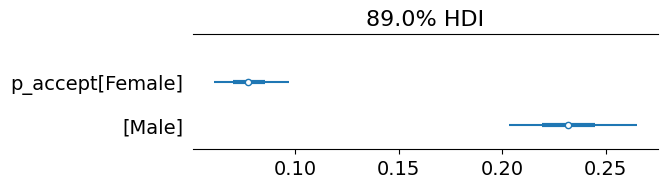

In [25]:
plot_admissions_model_posterior(total_effect_inference_simulated_biased, (6, 1.5))

## Fitting Direct Causal Effect Model on BIASED data

In [41]:
def fit_direct_effect_model_admissions(data):
    # Set up observations / coords
    n_admitted = data['admit'].values
    n_applications = data['applications'].values
    
    department_coded, department = pd.factorize(data['dept'].values)
    gender_coded, gender = pd.factorize(data['applicant.gender'].values)
    
    with pm.Model(coords={"gender": gender, "department": department}) as direct_effect_model:

        # Mutable data for running any gender-based or department-based counterfactuals
        gender_coded = pm.MutableData("gender", gender_coded, dims="obs_ids")
        department_coded = pm.MutableData("department", department_coded, dims="obs_ids")
        n_applications = pm.MutableData("n_applications", n_applications, dims="obs_ids")

        alpha = pm.Normal('alpha', 0, 1, dims=["department", "gender"])
        
        # Record inverse linked probabilities for reporting
        pm.Deterministic("p_accept", pm.math.invlogit(alpha), dims=['department', 'gender'])
        
        p = pm.math.invlogit(alpha[department_coded, gender_coded])
        
        likelihood = pm.Binomial("accepted", n=n_applications, p=p, observed=n_admitted, dims="obs_ids")
        direct_effect_inference = pm.sample()
    
    return direct_effect_model, direct_effect_inference

In [42]:
direct_effect_model_simulated_biased, direct_effect_inference_simulated_biased = fit_direct_effect_model_admissions(sim_data_grouped_biased)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


KeyboardInterrupt: 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[it, Female]",-1.659,0.245,-2.155,-1.212,0.004,0.003,3038.0,1485.0,1.0
"alpha[it, Male]",-0.812,0.114,-1.012,-0.587,0.002,0.002,2893.0,1806.0,1.0
"alpha[psych, Female]",-2.802,0.211,-3.215,-2.420,0.004,0.003,3322.0,1605.0,1.0
"alpha[psych, Male]",-2.410,0.277,-2.921,-1.893,0.005,0.004,3587.0,1520.0,1.0
"p_accept[it, Female]",0.163,0.033,0.098,0.222,0.001,0.000,3038.0,1485.0,1.0
"p_accept[it, Male]",0.308,0.024,0.267,0.357,0.000,0.000,2893.0,1806.0,1.0
"p_accept[psych, Female]",0.058,0.012,0.037,0.079,0.000,0.000,3322.0,1605.0,1.0
"p_accept[psych, Male]",0.085,0.021,0.047,0.125,0.000,0.000,3587.0,1520.0,1.0


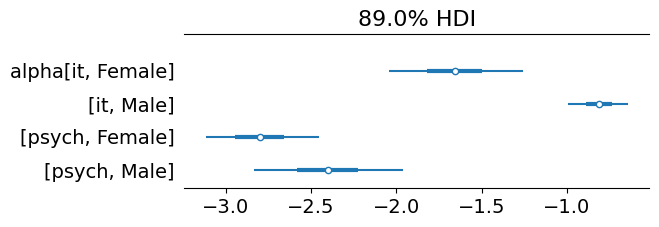

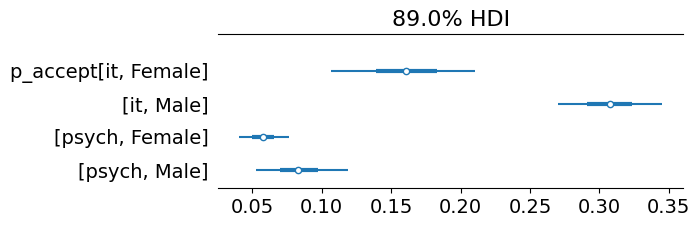

In [28]:
plot_admissions_model_posterior(direct_effect_inference_simulated_biased)

In [29]:
# For reference
# the biased acceptance rate for it is 0.2 for females. for psych its 0.05 for females. same as unbiased for males


#### FIT for unbiased data, firstly the total effect

In [34]:
total_effect_model_simulated_unbiased, total_effect_inference_simulated_unbiased = fit_total_effect_model_admissions(data=sim_data_grouped_unbiased)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Female],-1.978,0.133,-2.220,-1.725,0.003,0.002,1908.0,1498.0,1.0
alpha[Male],-1.088,0.100,-1.284,-0.914,0.002,0.002,1958.0,1293.0,1.0
p_accept[Female],0.122,0.014,0.097,0.150,0.000,0.000,1908.0,1498.0,1.0
p_accept[Male],0.252,0.019,0.217,0.286,0.000,0.000,1958.0,1293.0,1.0


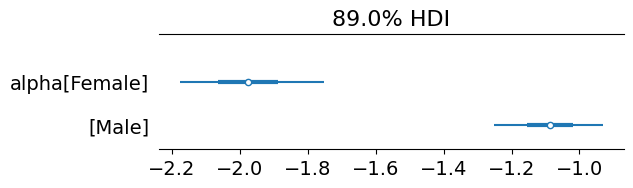

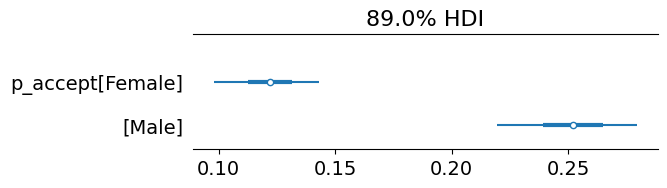

In [35]:
plot_admissions_model_posterior(total_effect_inference_simulated_unbiased, (6, 1.5))

#### Now for the direct effect, should be no bias in the coefficient if i understand it
Because we stratified by department, meaning removed its influence 

In [36]:
direct_effect_model_simulated_unbiased, direct_effect_inference_simulated_unbiased = fit_direct_effect_model_admissions(data=sim_data_grouped_unbiased)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[it, Female]",-1.011,0.205,-1.376,-0.605,0.004,0.003,3092.0,1499.0,1.0
"alpha[it, Male]",-0.716,0.117,-0.916,-0.482,0.002,0.001,3224.0,1565.0,1.0
"alpha[psych, Female]",-2.421,0.179,-2.740,-2.088,0.003,0.002,2978.0,1623.0,1.0
"alpha[psych, Male]",-2.191,0.262,-2.681,-1.731,0.004,0.003,3985.0,1718.0,1.0
"p_accept[it, Female]",0.269,0.040,0.199,0.349,0.001,0.001,3092.0,1499.0,1.0
"p_accept[it, Male]",0.329,0.026,0.280,0.376,0.000,0.000,3224.0,1565.0,1.0
"p_accept[psych, Female]",0.083,0.013,0.060,0.110,0.000,0.000,2978.0,1623.0,1.0
"p_accept[psych, Male]",0.103,0.024,0.061,0.146,0.000,0.000,3985.0,1718.0,1.0


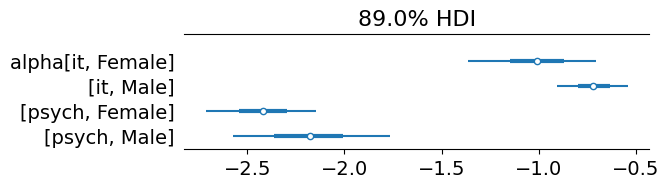

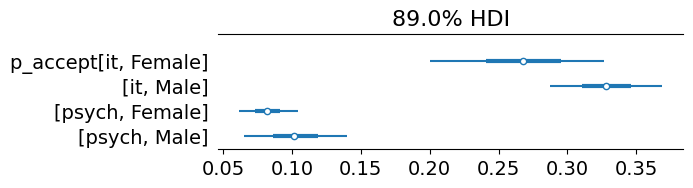

In [37]:
plot_admissions_model_posterior(direct_effect_inference_simulated_unbiased, (6, 1.5))

# 4. Analyze the UC Berkeley Admissions data

### Total causal effect

In [38]:
df

,dept,applicant.gender,admit,reject,applications,percent_of_addmisions
1,A,male,512,313,825,62.06
2,A,female,89,19,108,82.41
3,B,male,353,207,560,63.04
4,B,female,17,8,25,68.00
5,C,male,120,205,325,36.92
6,C,female,202,391,593,34.06
7,D,male,138,279,417,33.09
8,D,female,131,244,375,34.93
9,E,male,53,138,191,27.75
10,E,female,94,299,393,23.92


In [39]:
total_effect_model, total_effect_inference = fit_total_effect_model_admissions(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],-0.219,0.039,-0.290,-0.144,0.001,0.001,1957.0,1283.0,1.0
alpha[female],-0.828,0.050,-0.921,-0.737,0.001,0.001,2237.0,1454.0,1.0
p_accept[male],0.445,0.010,0.428,0.464,0.000,0.000,1957.0,1283.0,1.0
p_accept[female],0.304,0.011,0.285,0.324,0.000,0.000,2237.0,1454.0,1.0


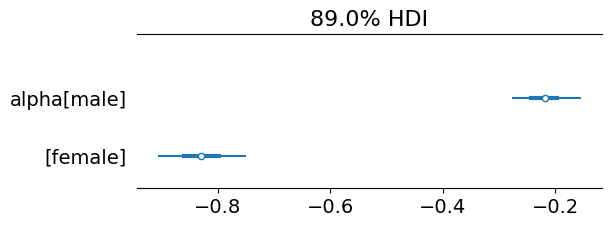

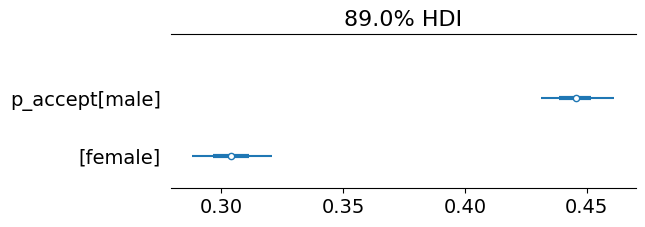

In [47]:
plot_admissions_model_posterior(total_effect_inference)

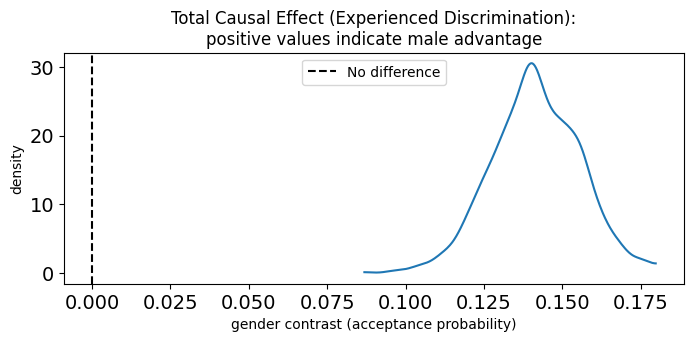

In [53]:
# Total Causal Effect
female_p_accept = total_effect_inference.posterior["p_accept"].sel(gender="female")
male_p_accept = total_effect_inference.posterior["p_accept"].sel(gender="male")
contrast = male_p_accept - female_p_accept

plt.subplots(figsize=(8, 3))
az.plot_dist(contrast)
plt.axvline(0, linestyle="--", color='black', label='No difference')
plt.xlabel("gender contrast (acceptance probability)")
plt.ylabel("density")
plt.title("Total Causal Effect (Experienced Discrimination):\npositive values indicate male advantage")
plt.legend();

In [54]:
direct_effect_model, direct_effect_inference = fit_direct_effect_model_admissions(data=df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[A, male]",0.492,0.073,0.354,0.627,0.001,0.001,2786.0,1567.0,1.0
"alpha[A, female]",1.470,0.244,1.022,1.919,0.005,0.004,2629.0,1298.0,1.0
"alpha[B, male]",0.532,0.084,0.370,0.690,0.001,0.001,3117.0,1464.0,1.0
"alpha[B, female]",0.659,0.403,-0.126,1.410,0.007,0.006,3388.0,1535.0,1.0
"alpha[C, male]",-0.527,0.115,-0.740,-0.315,0.002,0.002,2505.0,1536.0,1.0
"alpha[C, female]",-0.658,0.093,-0.833,-0.487,0.002,0.001,3186.0,1376.0,1.0
"alpha[D, male]",-0.697,0.107,-0.909,-0.508,0.002,0.001,3269.0,1279.0,1.0
"alpha[D, female]",-0.617,0.108,-0.827,-0.419,0.002,0.001,2885.0,1642.0,1.0
"alpha[E, male]",-0.937,0.163,-1.245,-0.631,0.003,0.002,2998.0,1530.0,1.0
"alpha[E, female]",-1.141,0.115,-1.352,-0.928,0.002,0.001,3129.0,1604.0,1.0


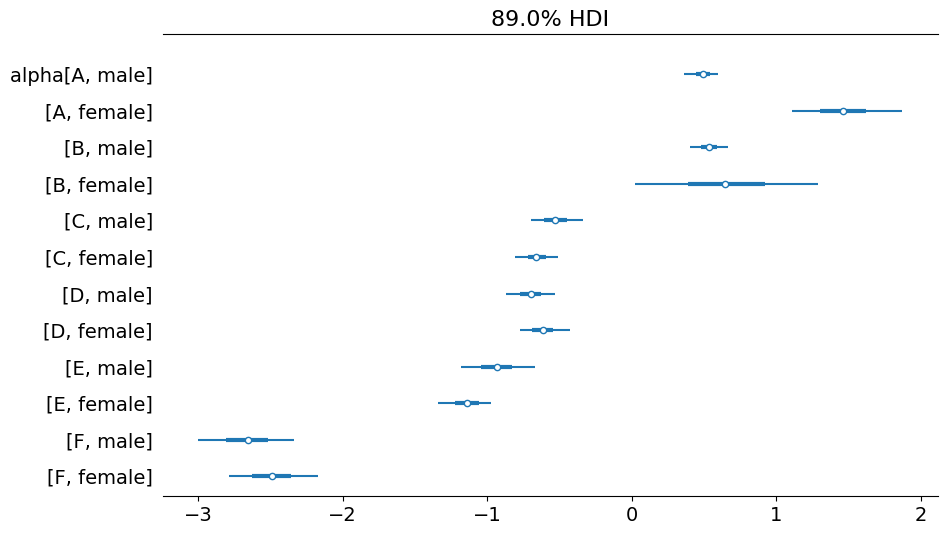

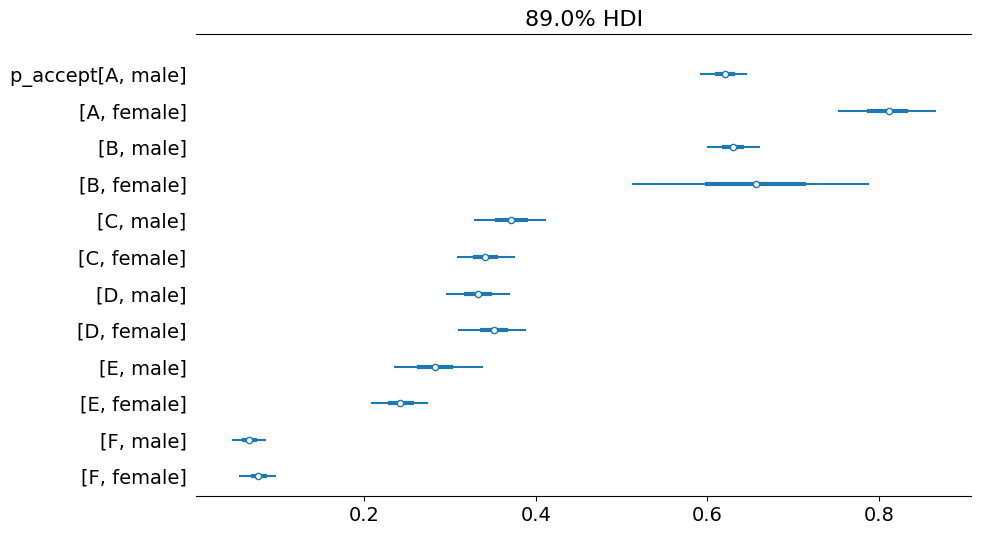

In [57]:
plot_admissions_model_posterior(direct_effect_inference, figsize=(10,6))


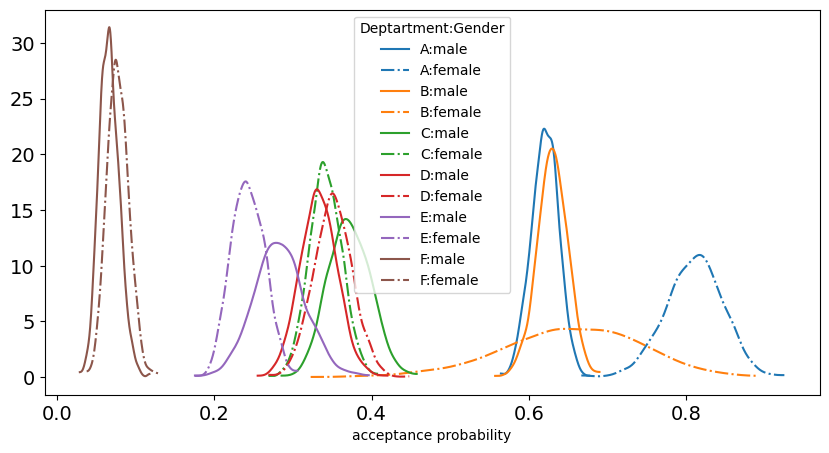

In [63]:
# Fancier plot of department/gender acceptance probability distributions
_, ax = plt.subplots(figsize=(10, 5))
for ii, dept in enumerate(df.dept.unique()):
    color = f"C{ii}"
    for gend in df["applicant.gender"].unique():
        label = f"{dept}:{gend}"
        linestyle = "-." if gend == 'female' else "-"
        post = direct_effect_inference.posterior['p_accept'].sel(department=dept, gender=gend)
        az.plot_dist(post, label=label, color=color, plot_kwargs={"linestyle": linestyle})
plt.xlabel("acceptance probability");
plt.legend(title='Deptartment:Gender');

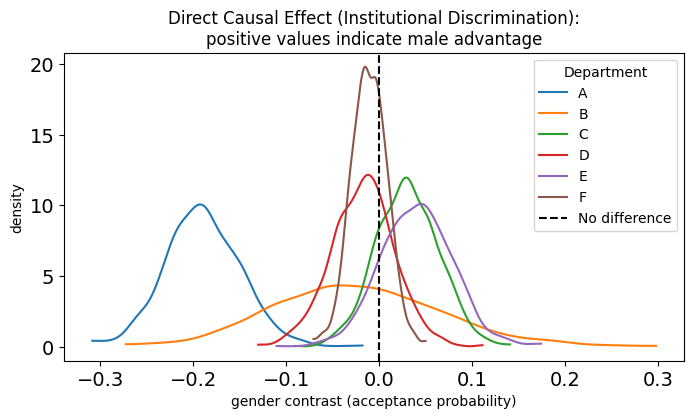

In [74]:
# Direct Causal Effect
_, ax = plt.subplots(figsize=(8, 4))

for ii, dept in enumerate(df.dept.unique()):
    color = f"C{ii}"
    label = f"{dept}"
    
    female_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="female", department=dept)
    male_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="male", department=dept)
    
    contrast = male_p_accept - female_p_accept
    az.plot_dist(contrast, color=color, label=label)
    
plt.xlabel("gender contrast (acceptance probability)")
plt.ylabel("density")
plt.title("Direct Causal Effect (Institutional Discrimination):\npositive values indicate male advantage")
plt.axvline(0, linestyle="--", color='black', label='No difference');
plt.legend(title='Department');

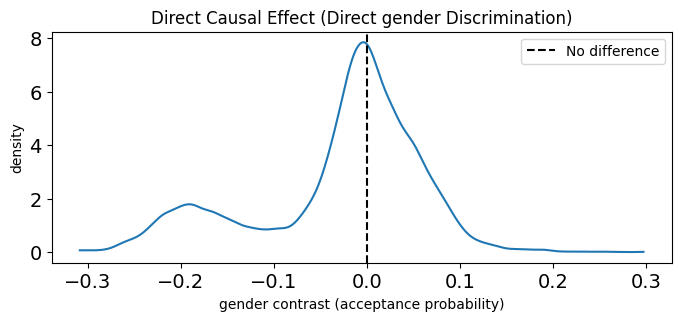

In [60]:
# Direct Causal Effect
female_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="female")
male_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="male")
contrast = male_p_accept - female_p_accept

plt.subplots(figsize=(8, 3))
az.plot_dist(contrast)
plt.axvline(0, linestyle="--", color='black', label='No difference')
plt.xlabel("gender contrast (acceptance probability)")
plt.ylabel("density")
plt.title("Direct Causal Effect (Direct gender Discrimination)")
plt.legend();

c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


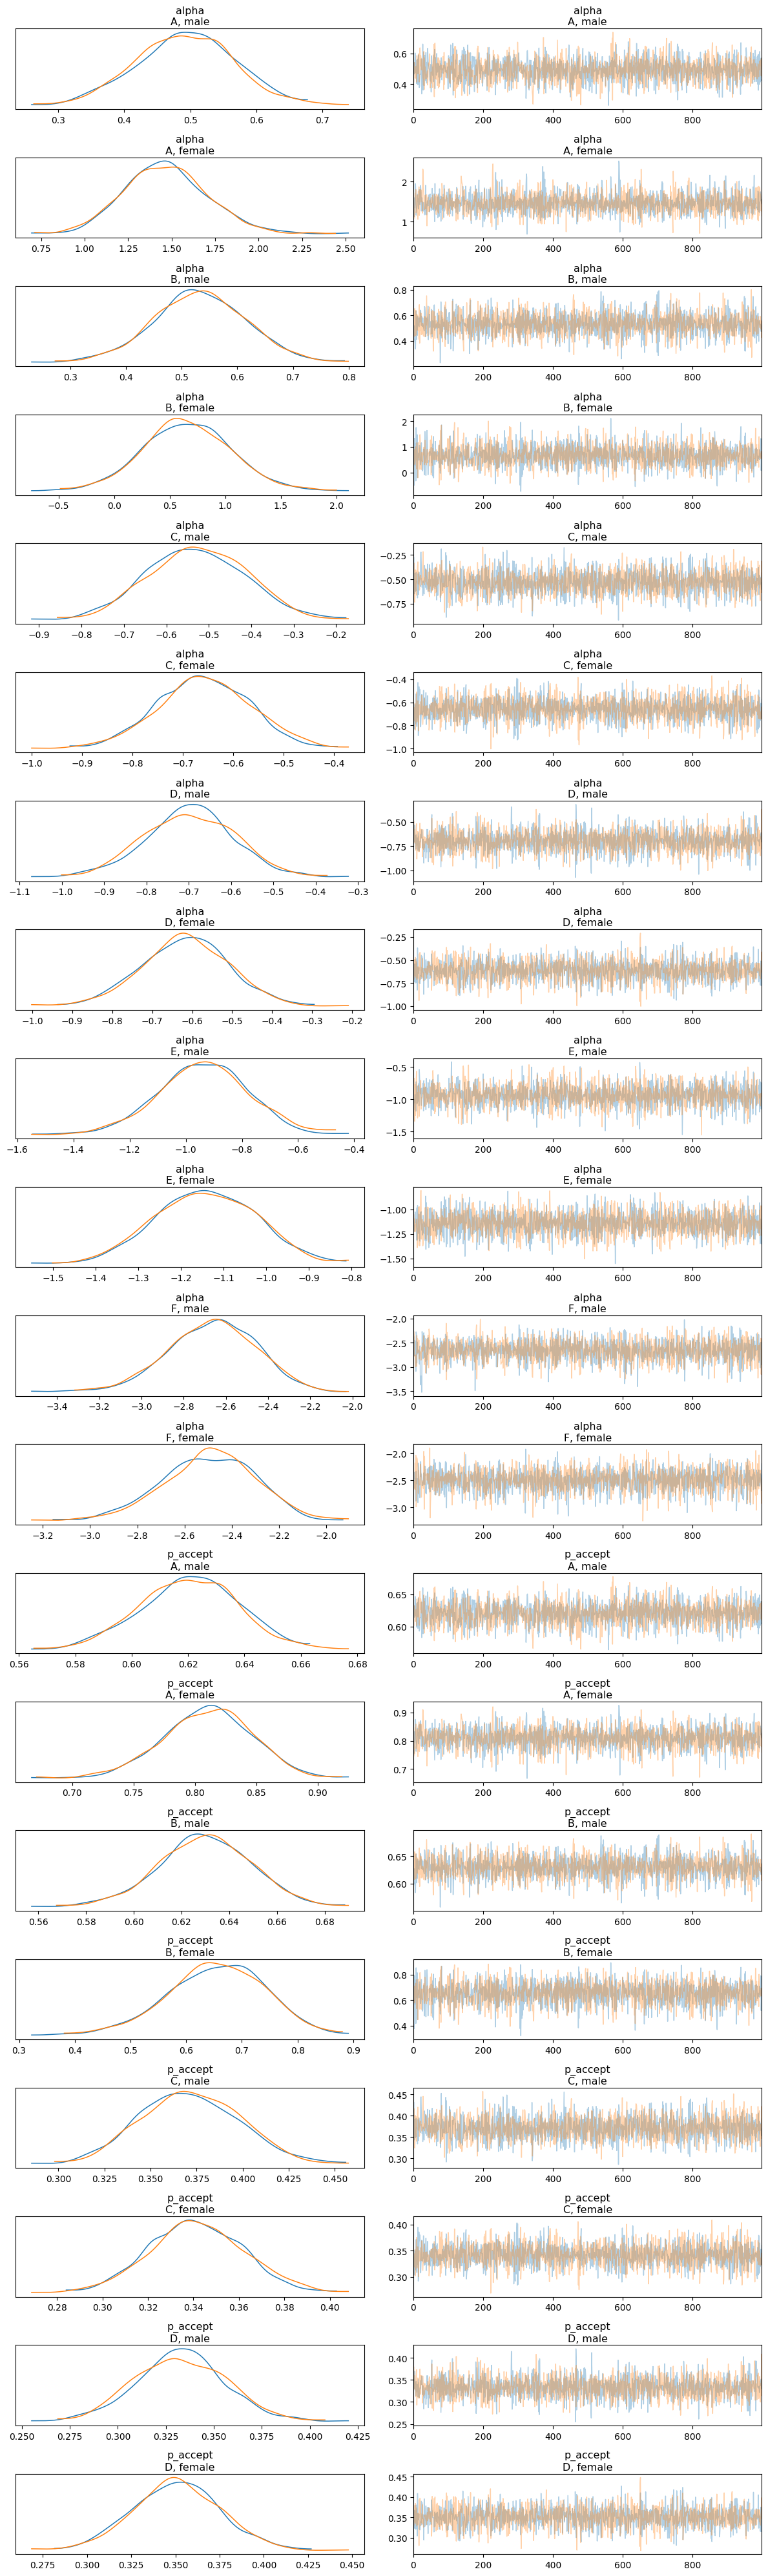

In [72]:
az.plot_trace(direct_effect_inference, compact=False)
plt.tight_layout()

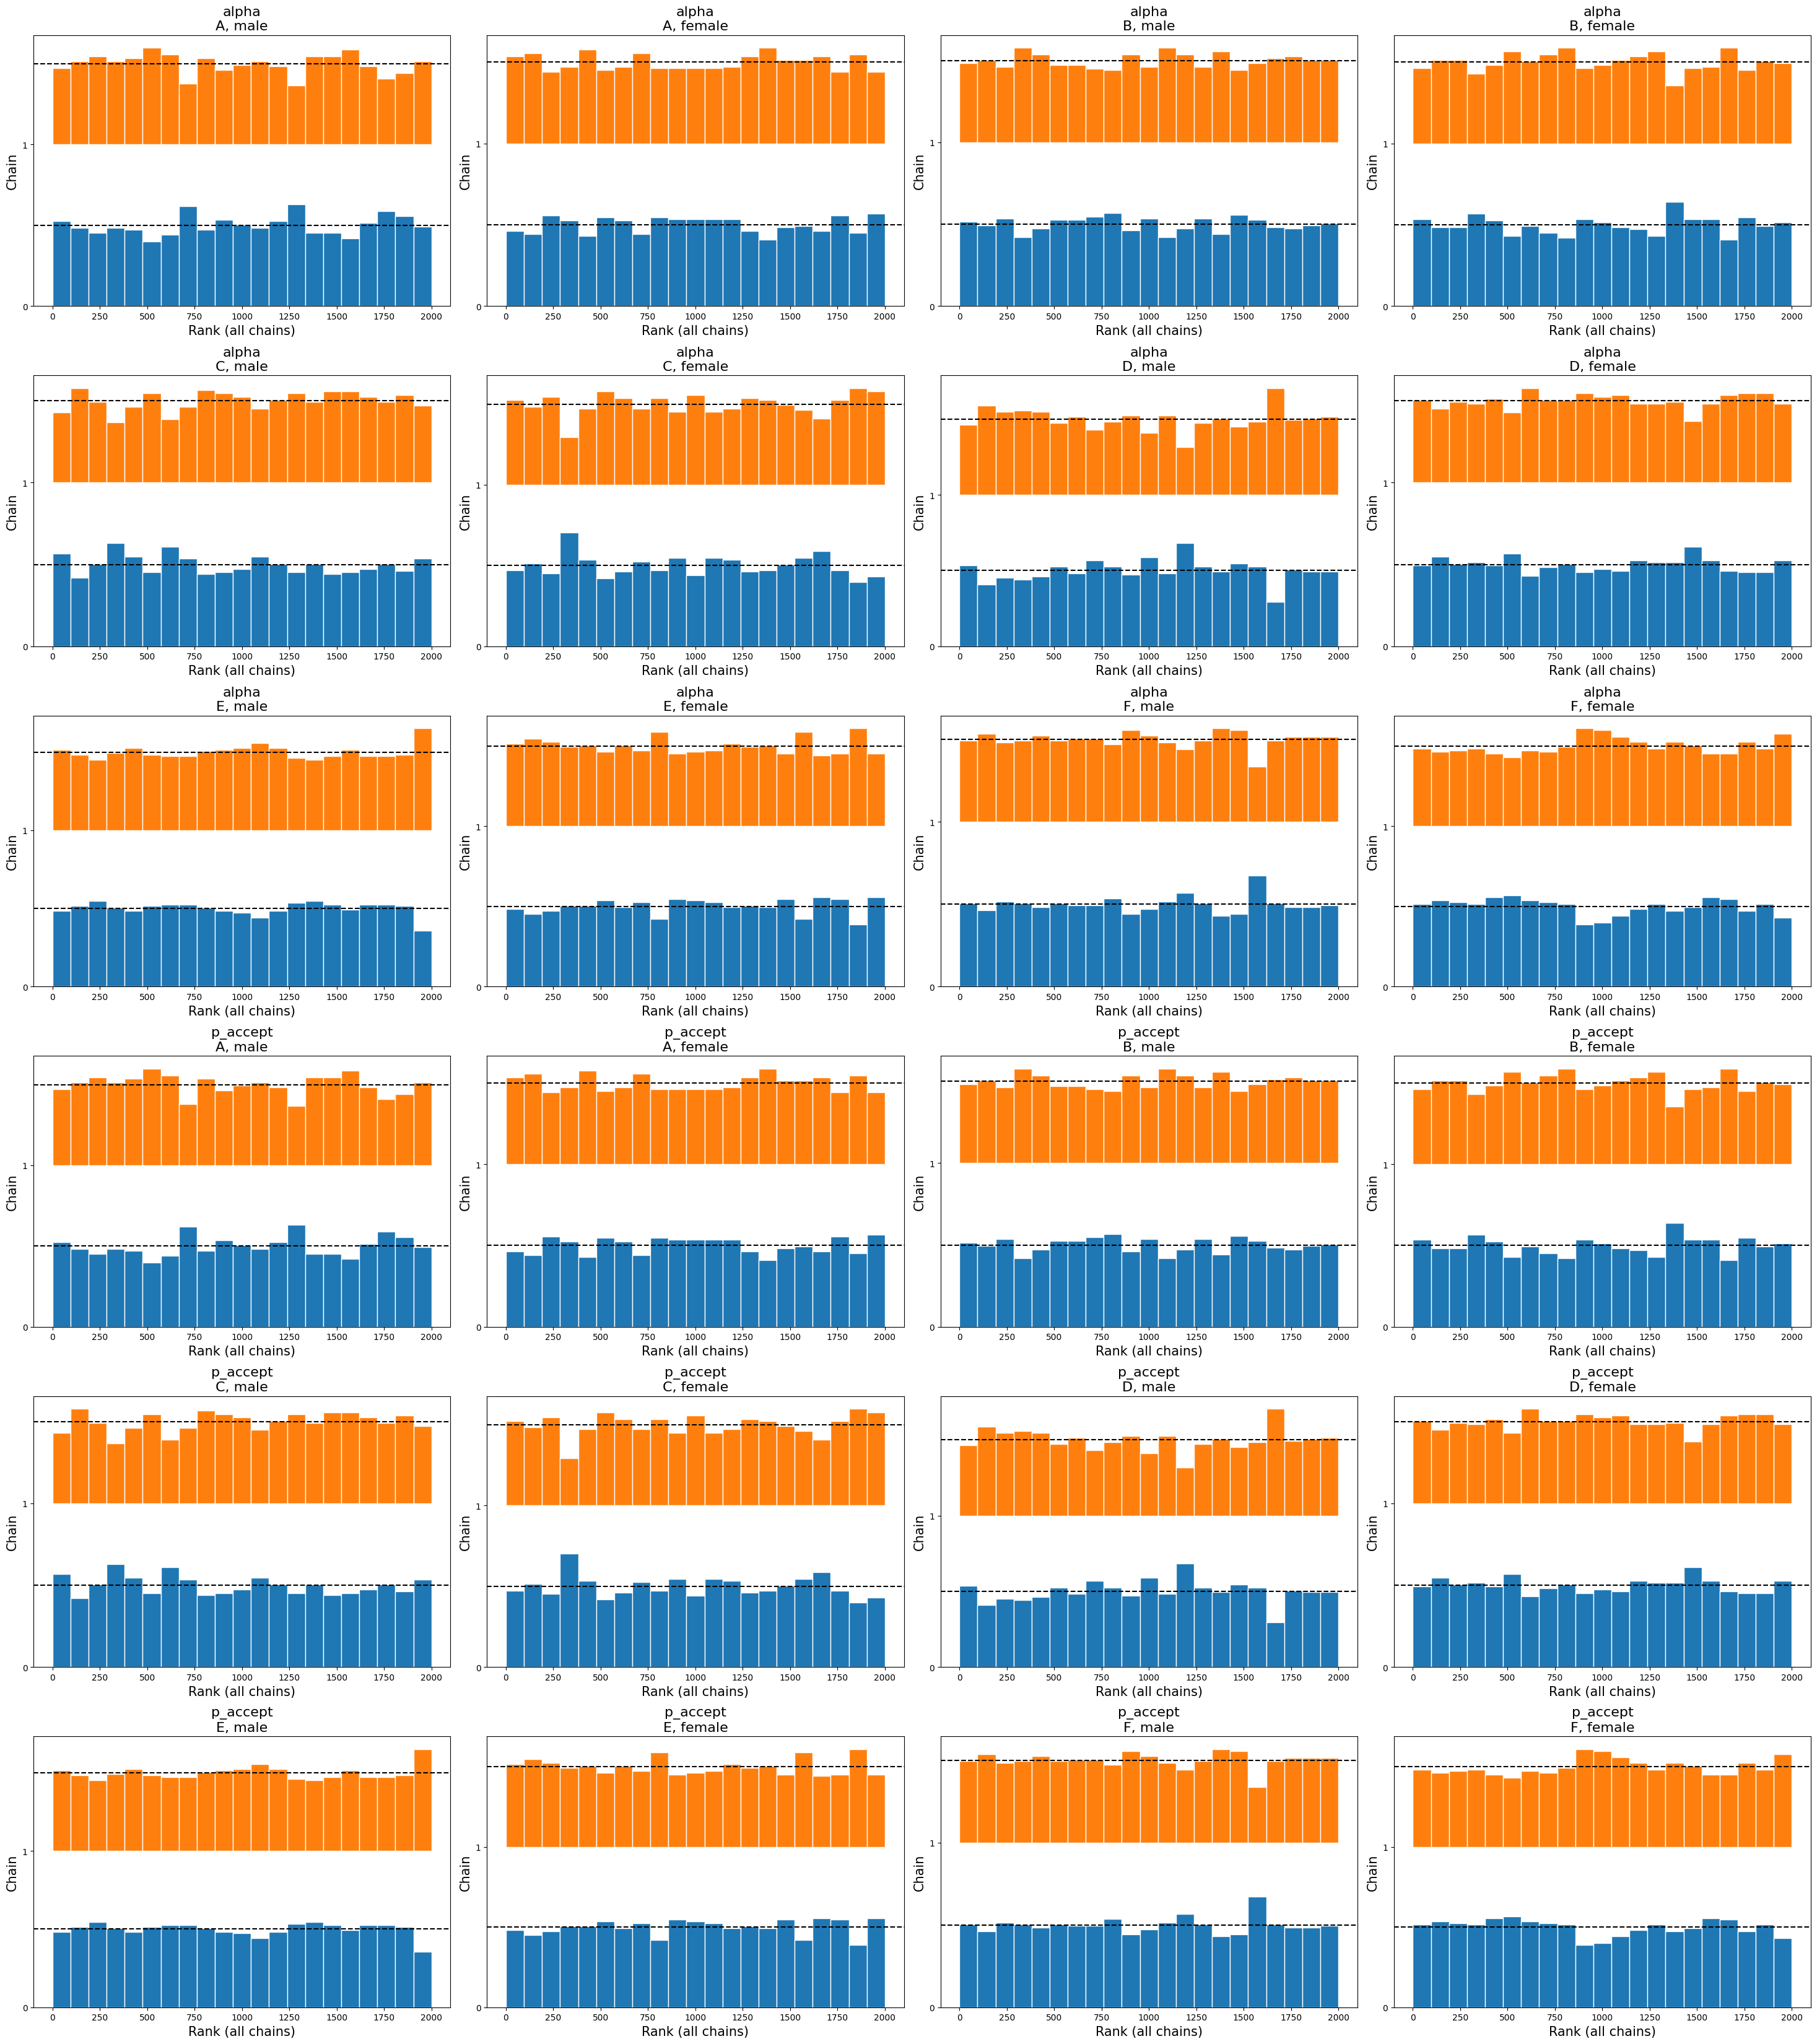

In [69]:
az.plot_rank(data=direct_effect_inference);plt.tight_layout();plt.show()

What we will do now is simulating an intervention on the perceived gender by the admissions officer.

We are not changing the amount of applications to each dept but only the interveening on gender.

In [81]:
df

,dept,applicant.gender,admit,reject,applications,percent_of_addmisions
1,A,male,512,313,825,62.06
2,A,female,89,19,108,82.41
3,B,male,353,207,560,63.04
4,B,female,17,8,25,68.00
5,C,male,120,205,325,36.92
6,C,female,202,391,593,34.06
7,D,male,138,279,417,33.09
8,D,female,131,244,375,34.93
9,E,male,53,138,191,27.75
10,E,female,94,299,393,23.92


In [80]:
df.groupby("dept")['applications'].sum()

dept
A    933
B    585
C    918
D    792
E    584
F    714
Name: applications, dtype: int64

#### Post-stratification
- **Re-weight estimates** for the target population
- allows us to apply model fit from one university to estiamte causal impact at another university with a different distribution of departments
- Here, we use the empirical distribution for re-weighting estimates

array([933, 585, 918, 792, 584, 714], dtype=int64)

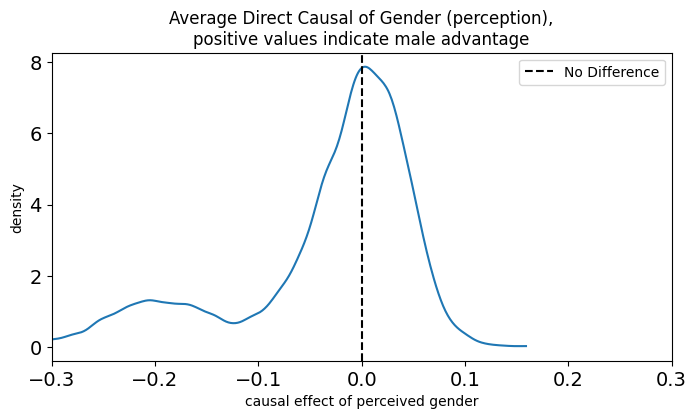

In [ ]:
# Use the empirical distribution of departments -- we'd update this for a different university
applications_per_dept = df.groupby('dept').sum()['applications'].values
total_applications = applications_per_dept.sum()
department_weight = applications_per_dept / total_applications

female_alpha = direct_effect_inference.posterior.sel(gender='female')['alpha']
male_alpha = direct_effect_inference.posterior.sel(gender='male')['alpha']

weighted_female_alpha = female_alpha * department_weight
weighed_male_alpha = male_alpha * department_weight

contrast = weighed_male_alpha - weighted_female_alpha

_, ax = plt.subplots(figsize=(8, 4))
az.plot_dist(contrast)

plt.axvline(0, linestyle='--', color='k', label='No Difference')
plt.xlabel("causal effect of perceived gender")
plt.ylabel("density")
plt.title("Average Direct Causal of Gender (perception),\npositive values indicate male advantage");
plt.xlim([-.3, .3])
plt.legend();


In [85]:
applications_per_dept/total_applications

array([0.20614229, 0.1292532 , 0.2028281 , 0.17498895, 0.12903226,
       0.15775519])

In [89]:
weighed_male_alpha

<xarray.DataArray 'alpha' (chain: 2, draw: 1000, department: 6)>
array([[[ 0.10963409,  0.0820662 , -0.16235585, -0.15617872,
         -0.09909356, -0.45143995],
        [ 0.09834664,  0.05228495, -0.05520697, -0.09309344,
         -0.15004867, -0.37404273],
        [ 0.11122916,  0.0670575 , -0.11832057, -0.11439602,
         -0.12936711, -0.41014553],
        ...,
        [ 0.11756371,  0.06120114, -0.10849607, -0.10709503,
         -0.14828808, -0.44593184],
        [ 0.10385536,  0.0654477 , -0.12283824, -0.12374163,
         -0.11798717, -0.46644065],
        [ 0.11232052,  0.07263032, -0.08828673, -0.11673016,
         -0.12346663, -0.38916738]],

       [[ 0.10088985,  0.08336562, -0.09531982, -0.11940622,
         -0.10920719, -0.43743274],
        [ 0.0846902 ,  0.06660136, -0.07333595, -0.08587137,
         -0.10712139, -0.35725423],
        [ 0.0999773 ,  0.07847948, -0.06797266, -0.11167028,
         -0.08684572, -0.36919628],
        ...,
        [ 0.09349566,  0.07186839, -0.12844601, -0.13637767,
         -0.11757073, -0.49728841],
        [ 0.11707681,  0.05528111, -0.06390352, -0.06510311,
         -0.12332683, -0.44563706],
        [ 0.09157165,  0.06073946, -0.10133709, -0.08437811,
         -0.1114883 , -0.41520656]]])
Coordinates:
  * chain       (chain) int32 0 1
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * department  (department) <U1 'A' 'B' 'C' 'D' 'E' 'F'
    gender      <U6 'male'

# BONUS: SURVIVAL ANALYSIS OR TIME TO EVENT ANALYSIS

Important not to ignore the "censored" cases, which are events that have not yet ended before the observation took place. Also its the cases where the time started is unknown. Cant throw out censored cases, because it leads to inferential errors

## Example: Austin Cat Adoption

- 20k cats
- Events: adopted (1) or not (0)
- Censoring mechanisms
  - death before adoption
  - escape
  - not adopted yet

**Goal**: determine if Black cats are adopted at a lower rate than non-Black cats.

In [92]:
CATS = utils.load_data('AustinCats')
CATS.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


<Axes: xlabel='days_to_event'>

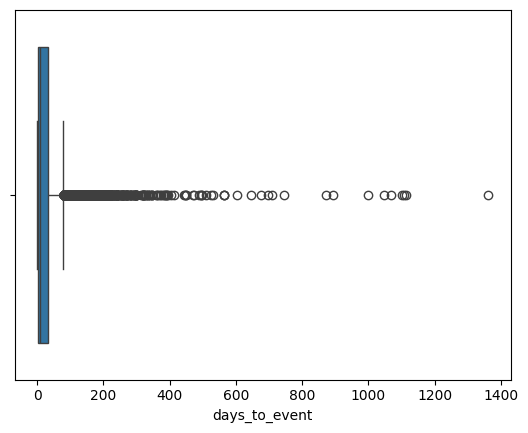

In [95]:
sns.boxplot(data=CATS, x="days_to_event")

What would be a good distribution for the outcome variable (days to event)?
* What are the constraints
    * Its a positive number
    * Its a latency
* Either Gamma or Exp

We choose Exp, so we have to choose a lambda param
* inverse rate(lambda) is the avg waiting time, SO
    * 1/lambda=avg_time_to_event

In [99]:
avg_time_to_event = CATS["days_to_event"].mean()
lambda_ = 1/avg_time_to_event

In [100]:
lambda_

0.039700805523590336

#### How to handle the censored events?
* CCDF
    * so for a cdf at time x=2 the cumulative probability is close to 0.8, for a ccdf for x = 2 is close to 0.2(what is the prob of the cat not yet being adopted at this time?)
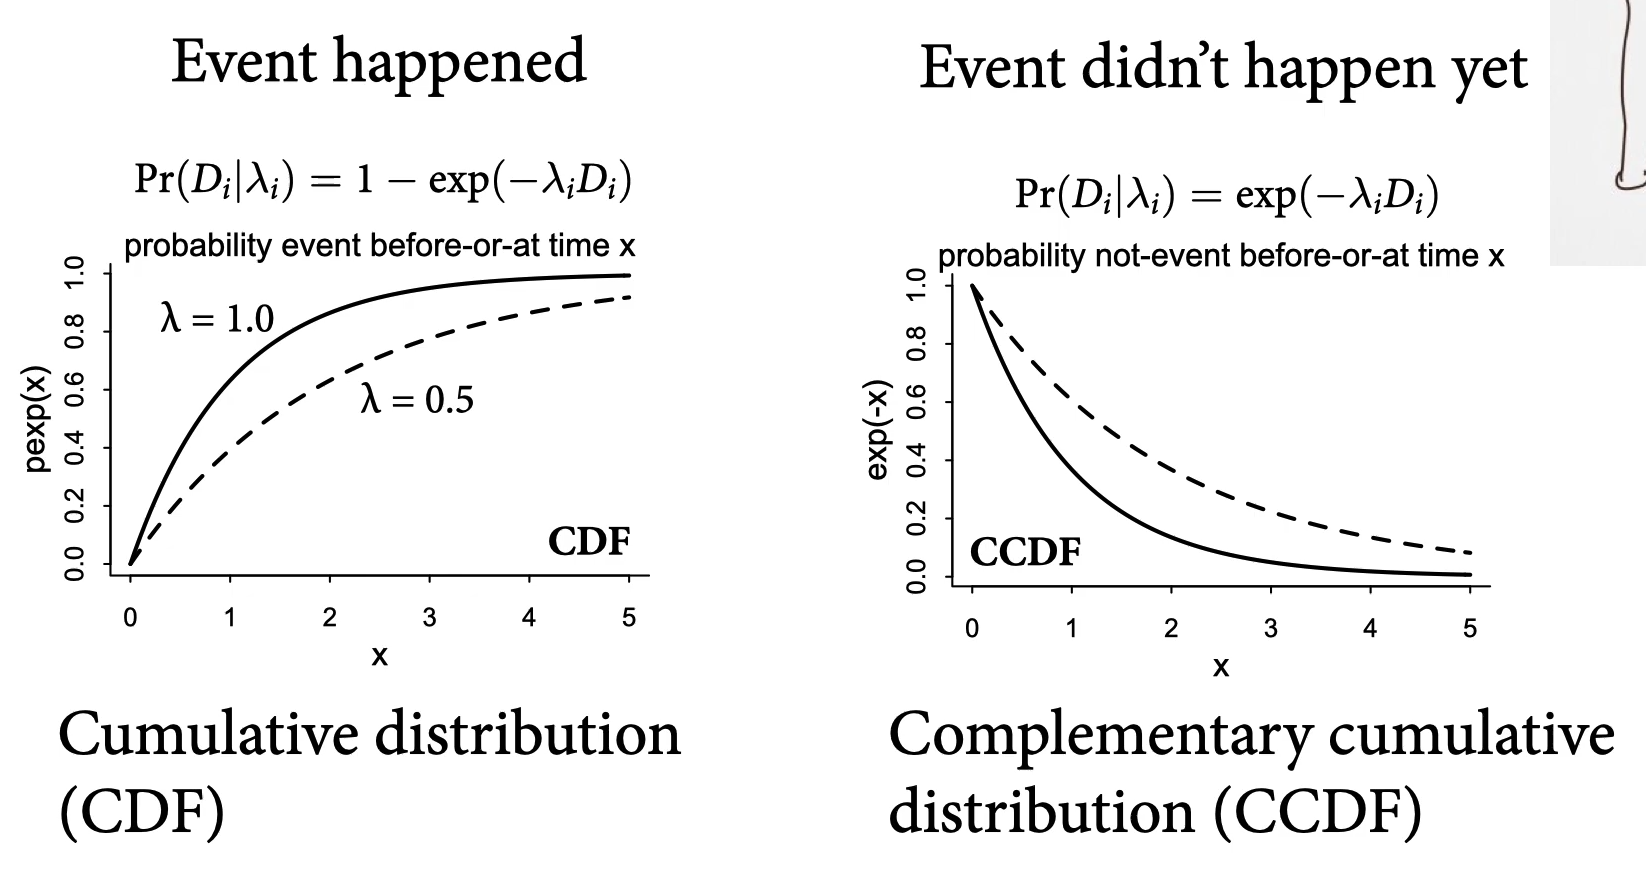

* Di|Ai = 1 ~ Exp(lambda_i)
* Di|Ai = 0 ~ Exp-CCDF(lambda_i)

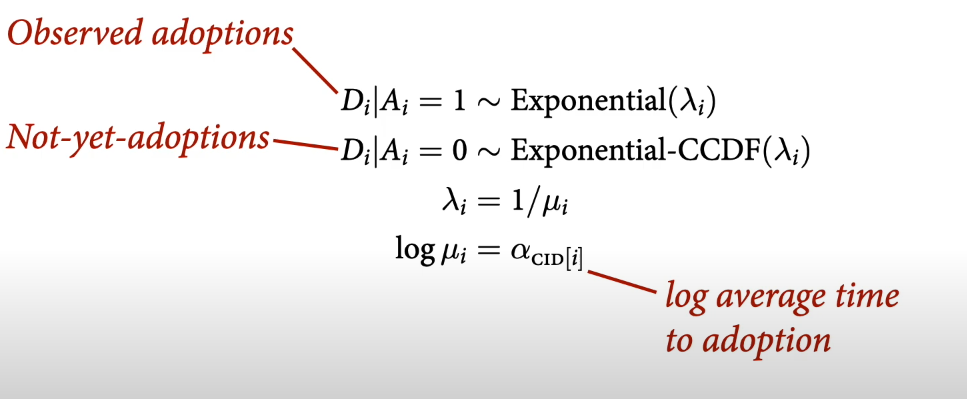

- $D_i | A_i = 1$ - observed adoptions
- $D_i | A_i = 1$ - not-yet-observed adoptions
- $\alpha_{\text{cat color}[i]}$ log average time-to-adoption for each cat color
- $\log \mu_i$ -- link function ensures $\alpha$s are positive
- $\lambda_i = \frac{1}{\mu_i}$ simplifies estimating average **time-to-adoption**

In [ ]:
CAT_COLOR_ID, CAT_COLOR = pd.factorize(CATS.color.apply(lambda x: "Other" if x != 'Black' else x))
ADOPTED_ID, ADOPTED = pd.factorize(CATS.out_event.apply(lambda x: "Other" if x != "Adoption" else 'Adopted'))
DAYS_TO_ADOPTION = CATS.days_to_event.values.astype(float)
LAMBDA = lambda_

25.18840579710145

In [ ]:
right_censoring = DAYS_TO_ADOPTION.copy()
right_censoring[ADOPTED_ID == 0] = DAYS_TO_ADOPTION.max()



array([ 1., 25.,  4., ...,  6.,  9.,  6.])

In [111]:
with pm.Model(coords={"cat_color": CAT_COLOR}) as adoption_model:
    
    # Censoring
    right_censoring = DAYS_TO_ADOPTION.copy()
    right_censoring[ADOPTED_ID == 0] = DAYS_TO_ADOPTION.max()
    
    # Priors    
    lambda_ = LAMBDA
    alpha = pm.Exponential("alpha", lambda_, dims="cat_color")
    
    # Likelihood
    log_adoption_rate = 1 / alpha[CAT_COLOR_ID]
    pm.Censored(
        "adopted",
        pm.Exponential.dist(lam=log_adoption_rate),
        lower=None,
        upper=right_censoring,
        observed=DAYS_TO_ADOPTION
    )
    adoption_inference = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


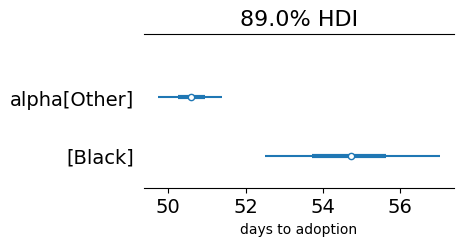

In [112]:
_, ax = plt.subplots(figsize=(4, 2))
az.plot_forest(adoption_inference, var_names=['alpha'], combined=True, hdi_prob=.89, ax=ax)
plt.xlabel("days to adoption");

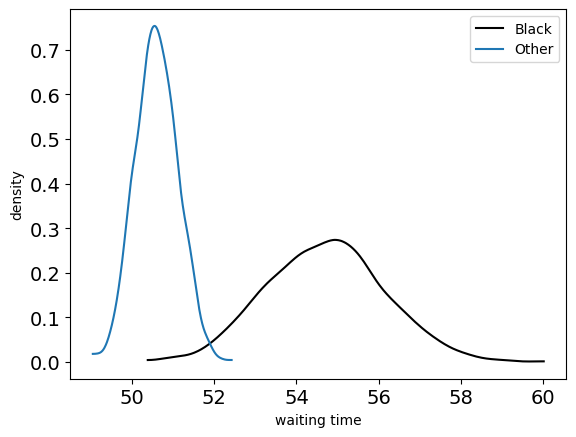

In [113]:
for ii, cat_color in enumerate(["Black", "Other"]):
    color = 'black' if cat_color == 'Black' else "C0"
    posterior_alpha = adoption_inference.posterior.sel(cat_color=cat_color)['alpha']
    az.plot_dist(posterior_alpha, color=color, label=cat_color)
plt.xlabel("waiting time")
plt.ylabel("density")
plt.legend();